# NoteBook to Make Descriptives

This notebook is for looking at final population zonal stats data

In [1]:
from rasterstats import zonal_stats
import rasterio
import geopandas as gpd
import operator
import numpy as np
import pandas as pd
import matplotlib 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce
import squarify

# Functions

In [ ]:
def city_search(gpd_df, city_list, country):
    """ function will print out city name and population for a subset of a gridded dataset gpd
    requires data frame, list of cities, and country of interest
    """
    gpd_df_sub = gpd_df[gpd_df['country'] == country]
    
    for index, row in gpd_df_sub.iterrows():
        for city in city_list:
            if row['city'] == city:
                print(city)
                print(round(row['PopTot']))

In [ ]:
def str_id(gpd_df):
    """
    Function makes a new col with a unique lat-lon string to identify each osm point & drops duplicates
    Function also makes
    """

    
    print(gpd_df.shape)
    
    lat_string = gpd_df.lat.astype(str)
    lon_string = gpd_df.lon.astype(str)
    gpd_df['str_id'] = lat_string.astype(str)+lon_string.astype(str)
    
    print(gpd_df.shape)


In [ ]:
def dup_drop(gpd_in, col, keep_dup):
    """ 
    function drops duplicates based on a column from a pd data frame
    requires pd df out string, pd df, col name, and which dup to keep
    returns new gpd_df
    """
    
    gpd_out = gpd.GeoDataFrame()
    
    print(gpd_in.shape)
    
    gpd_out = gpd_in.drop_duplicates(col, keep = keep_dup)
    
    print(gpd_out.shape)

    return gpd_out

    

In [ ]:
def df_merge(df_left, df_right):
    
    pd_out = pd.DataFrame()
    pd_out = pd.merge(df_left[['str_id', 'PopTot']], df_right[['str_id', 'PopTot']], on='str_id', how = 'inner')
    
    left_pop = pd_out.PopTot_x.astype(str)
    right_pop = pd_out.PopTot_y.astype(str)
    pd_out['pop_id'] = left_pop.astype(str)+right_pop.astype(str)

    return pd_out

In [ ]:
def p_X_gt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data>=x)/n_data for x in X ])

def p_X_lt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data<=x)/n_data for x in X ])

# Data

In [2]:
# File paths

data_raw = '/Users/cascade/Github/NTL/data/raw/'
data_temp = '/Users/cascade/Github/NTL/temp_data/'
data_interim = '/Users/cascade/Github/NTL/data/interim/'
ms_data = '/Users/cascade/Github/NTL/temp_data/MS_Data/'
erl_data = '/Users/cascade/Github/NTL/temp_data/ERL_data/'
downloads = '/Users/cascade/Downloads/'

In [3]:
# Data

GHS2000 = gpd.read_file(erl_data+'GHS_POP_GPW42000_final20190122.shp')
GHS2015 = gpd.read_file(erl_data+'GHS_POP_GPW42015_final20190122.shp')
WP2000 = gpd.read_file(erl_data+'AFR_PPP_2000_adj_v2_final20190122.shp')
WP2015 = gpd.read_file(erl_data+'AFR_PPP_2015_adj_v2_final20190122.shp')
LS2015 = gpd.read_file(erl_data+'WPE_1KM_2016_final20190122.shp')
WPE2016 = gpd.read_file(erl_data+'LS15_final20190122.shp')

In [4]:
# List of datasets

datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

In [5]:
GHS2000.head(6)

,osm_id,FID,country,city,osm_type,lat,lon,PopTot,aez_class,geometry
0,89369215,5382,Algeria,Tamanrasset,town,22.785454,5.532446,3.091468e+04,Tropic - cool / arid,"POLYGON ((5.512930562910484 22.80475188764244,..."
1,252600742,624,Algeria,Boumerdès,town,36.758882,3.470596,4.041199e+06,Subtropic - warm / subhumid,"POLYGON ((2.960095682991406 36.82071885667166,..."
2,253167052,195,Algeria,Thenia,town,36.724986,3.556935,2.767512e+04,Subtropic - warm / subhumid,"POLYGON ((3.610972972741118 36.75033076389462,..."
3,253167208,150,Algeria,Zemmouri,town,36.786406,3.601221,2.016720e+04,Subtropic - warm / subhumid,"POLYGON ((3.555512812300016 36.81191901602259,..."
4,253291208,436,Algeria,Lakhdaria,town,36.563944,3.596907,4.186613e+04,Subtropic - warm / subhumid,"POLYGON ((3.548917172615572 36.58325611006445,..."
5,253292622,257,Algeria,Draâ Ben Khedda,town,36.733332,3.958769,3.400638e+05,Subtropic - warm / subhumid,"POLYGON ((3.842424792309737 36.82951907750196,..."


# Group Data

### Add regions

Add new column that adds the region for each city

In [6]:
### List of African Countries from the UN in OSM wiki

Northern_Africa = (['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Western Sahara'], 'Northern_Africa')

Eastern_Africa = ([
    'Burundi',
    'Comoros',
    'Djibouti',
    'Eritrea',
    'Ethiopia',
    'Kenya',
    'Madagascar',
    'Malawi',
    'Mauritius',
    #Mayotte,
    'Mozambique',
    'Réunion',
    'Rwanda',
    'Somalia',
    'Sudan',
    'Uganda',
    'Tanzania',
    'Zambia',
    'Zimbabwe'], 'Eastern_Africa')
    
Middle_Africa = ([
    'Angola',
    'Cameroon',
    'Central African Republic',
    'Chad',
    'Congo-Brazzaville',
    'Congo-Kinshasa',
    'Equatorial Guinea',
    'Gabon',
    'Sao Tome and Principe'], 'Middle_Africa')
    
Southern_Africa = ([
    'Botswana',
    'Lesotho',
    'Namibia',
    'South Africa',
    'Swaziland'], 'Southern_Africa')
    
Western_Africa = ([
    'Benin',
    'Burkina Faso',
    'Cape Verde',
    'Côte d\'Ivoire',
    'Gambia',
    'Ghana',
    'Guinea',
    'Guinea-Bissau',
    'Liberia',
    'Mali',
    'Mauritania',
    'Niger',
    'Nigeria',
    'Senegal',
    'Sierra Leone',
    'Togo'], 'Western_Africa')

In [7]:
regions = [Northern_Africa, Western_Africa, Eastern_Africa, Southern_Africa, Middle_Africa]

In [8]:
def region(gpd_df, regions_list):
    "Function adds a new col to a df based on region"
    arr =[]
    for region in regions_list:
        for country in region[0]:
            for i, row in gpd_df.iterrows():
                if row['country'] == country:
                    #row['region'] = region[1] 
                    #df_copy.iloc[i] = row
                    #region[1]
                    arr.append(region[1])
    gpd_df['region'] = arr
    
    return gpd_df

In [9]:
for dataset in datasets_in:
    dataset = region(dataset, regions)

##  AZE to Rain Zones

create new column for each dataset that includes a cities rain climate 

In [10]:
# Group my rainfall zone

arid = (['Temperate / arid', 
         'Subtropic - warm / arid', 
         'Subtropic - cool / arid', 
         'Tropic - warm / arid',
         'Tropic - cool / arid'], 'Arid')

semi_arid = (['Temperate / Semi-arid', 
              'Subtropic - warm / semiarid', 
              'Subtropic - cool / semiarid',
              'Tropic - warm / semiarid', 
              'Tropic - cool / semiarid'], 'Semi-arid')    

sub_humid = (['Temperate / sub-humid', 
              'Subtropic - warm / subhumid', 
              'Subtropic - cool / subhumid',
              'Tropic - warm / subhumid', 
              'Tropic - cool / subhumid'], 'Sub-humid')

humid = (['Temperate / humid', 
          'Subtropic - warm / humid', 
          'Subtropic - cool / humid', 
          'Tropic - warm / humid',
          'Tropic - cool / humid'], 'Humid')

boreal = (['Boreal'], 'Boreal')

na = (['NoClass', '0'], 'NA')

rain_list = [arid, semi_arid, sub_humid, humid, boreal, na]

In [11]:
def rain_zone(gpd_df, rain_list):
    "function adds a new col to a gpd_df based on rain fall zone"
    arr =[]
    for rain_zone in rain_list:
        for aez in rain_zone[0]:
            for i, row in gpd_df.iterrows():
                if row['aez_class'] == aez:
                    arr.append(rain_zone[1])
                
    gpd_df['rain_zone'] = arr
    
    return gpd_df

In [12]:
for dataset in datasets_in:
    dataset = rain_zone(dataset, rain_list)

# Distrubutions

### Chunk by city size figures

In [16]:
# Drop Duplicate FIDs (Polygons) and <5000 people 

print('1---WP2015---') # World Pop 2015

# drop FID
print(len(WP2015))
WP2015 = WP2015.drop_duplicates('FID', keep = 'first')
print(len(WP2015))

# drop <5000
WP2015 = WP2015[WP2015['PopTot'] > 5000]
print(len(WP2015))

print('2---LS2015---') # LandScan 2015
# drop FID
print(len(LS2015))
LS2015 = LS2015.drop_duplicates('FID', keep = 'first')
print(len(LS2015))

# drop <5000
LS2015 = LS2015[LS2015['PopTot'] > 5000]
print(len(LS2015))

print('3---WPE2016---') # WPE 2016
# drop FID
print(len(WPE2016))
WPE2016 = WPE2016.drop_duplicates('FID', keep = 'first')
print(len(WPE2016))

# drop <5000
WPE2016 = WPE2016[WPE2016['PopTot'] > 5000]
print(len(WPE2016))

print('4---GHS2015---') # GHS 2015
# drop FID
print(len(GHS2015))
GHS2015 = GHS2015.drop_duplicates('FID', keep = 'first')
print(len(GHS2015))

# drop <5000
GHS2015 = GHS2015[GHS2015['PopTot'] > 5000]
print(len(GHS2015))

print('5---GHS2000---') # GHS 2000
# drop FID
print(len(GHS2000))
GHS2000 = GHS2000.drop_duplicates('FID', keep = 'first')
print(len(GHS2000))

# drop <5000
GHS2000 = GHS2000[GHS2000['PopTot'] > 5000]
print(len(GHS2000))

      
print('6---WP2000---') # World Pop 2000

# drop FID
print(len(WP2000))
WP2000 = WP2000.drop_duplicates('FID', keep = 'first')
print(len(WP2000))

# drop <5000
WP2000 = WP2000[WP2000['PopTot'] > 5000]
print(len(WP2000))

1---WP2015---
2411
2411
2411
2---LS2015---
3801
3801
3801
3---WPE2016---
3643
3643
3643
4---GHS2015---
4162
4162
4162
5---GHS2000---
3858
3858
3858
6---WP2000---
2061
2061
2061


### Chunk by Rain Zone

In [ ]:
WP2015.rain_zone.unique()

In [30]:
# Chunk by country 

GHS2015_arid = GHS2015[GHS2015['rain_zone'] == 'Arid']
GHS2015_semi = GHS2015[GHS2015['rain_zone'] == 'Semi-arid']
GHS2015_sub = GHS2015[GHS2015['rain_zone'] == 'Sub-humid']
GHS2015_humid = GHS2015[GHS2015['rain_zone'] == 'Humid']

In [31]:
# GHS 2015 Arid Chunks 
GHS2015_arid_50k = GHS2015_arid.loc[(GHS2015_arid['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_arid_50k)

GHS2015_arid_100k = GHS2015_arid.loc[(GHS2015_arid['PopTot'] > 5*10**4) & (GHS2015_arid['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_arid_100k)

GHS2015_arid_250k = GHS2015_arid.loc[(GHS2015_arid['PopTot'] > 10**5) & (GHS2015_arid['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_arid_250k)

GHS2015_arid_500k = GHS2015_arid.loc[(GHS2015_arid['PopTot'] > 2.5*10**5) & (GHS2015_arid['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_arid_500k)

GHS2015_arid_1m = GHS2015_arid.loc[(GHS2015_arid['PopTot'] > 5*10**5) & (GHS2015_arid['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_arid_1m)

GHS2015_arid_5m = GHS2015_arid.loc[(GHS2015_arid['PopTot'] > 10**6) & (GHS2015_arid['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_arid_5m)

GHS2015_arid_5mplus = GHS2015_arid.loc[(GHS2015_arid['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_arid_5mplus)

5770211.521161437
3974446.5933306217
3445686.148130417
3012814.759683758
2251999.9842593074
1352429.253856659
84495435.74569127


In [32]:
# GHS Semi Arid Chunks 
GHS2015_semi_50k = GHS2015_semi.loc[(GHS2015_semi['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_semi_50k)

GHS2015_semi_100k = GHS2015_semi.loc[(GHS2015_semi['PopTot'] > 5*10**4) & (GHS2015_semi['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_semi_100k)

GHS2015_semi_250k = GHS2015_semi.loc[(GHS2015_semi['PopTot'] > 10**5) & (GHS2015_semi['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_semi_250k)

GHS2015_semi_500k = GHS2015_semi.loc[(GHS2015_semi['PopTot'] > 2.5*10**5) & (GHS2015_semi['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_semi_500k)

GHS2015_semi_1m = GHS2015_semi.loc[(GHS2015_semi['PopTot'] > 5*10**5) & (GHS2015_semi['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_semi_1m)

GHS2015_semi_5m = GHS2015_semi.loc[(GHS2015_semi['PopTot'] > 10**6) & (GHS2015_semi['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_semi_5m)

GHS2015_semi_5mplus = GHS2015_semi.loc[(GHS2015_semi['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_semi_5mplus)

22887255.830865383
13523285.991266012
14757975.32088276
6357784.566317558
14059697.816293955
58506450.84650712
25704383.67055829


In [33]:
# GHS Sub Humid Chunks 
GHS2015_sub_50k = GHS2015_sub.loc[(GHS2015_sub['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_sub_50k)

GHS2015_sub_100k = GHS2015_sub.loc[(GHS2015_sub['PopTot'] > 5*10**4) & (GHS2015_sub['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_sub_100k)

GHS2015_sub_250k = GHS2015_sub.loc[(GHS2015_sub['PopTot'] > 10**5) & (GHS2015_sub['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_sub_250k)

GHS2015_sub_500k = GHS2015_sub.loc[(GHS2015_sub['PopTot'] > 2.5*10**5) & (GHS2015_sub['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_sub_500k)

GHS2015_sub_1m = GHS2015_sub.loc[(GHS2015_sub['PopTot'] > 5*10**5) & (GHS2015_sub['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_sub_1m)

GHS2015_sub_5m = GHS2015_sub.loc[(GHS2015_sub['PopTot'] > 10**6) & (GHS2015_sub['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_sub_5m)

GHS2015_sub_5mplus = GHS2015_sub.loc[(GHS2015_sub['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_sub_5mplus)

23833664.20226693
16092062.637963295
23186649.741491795
10931440.236400746
7528483.759854794
50175299.94110024
21692588.16485355


In [36]:
# GHS Humid Chunks 
GHS2015_humid_50k = GHS2015_humid.loc[(GHS2015_humid['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_humid_50k)

GHS2015_humid_100k = GHS2015_humid.loc[(GHS2015_humid['PopTot'] > 5*10**4) & (GHS2015_humid['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_humid_100k)

GHS2015_humid_250k = GHS2015_humid.loc[(GHS2015_humid['PopTot'] > 10**5) & (GHS2015_humid['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_humid_250k)

GHS2015_humid_500k = GHS2015_humid.loc[(GHS2015_humid['PopTot'] > 2.5*10**5) & (GHS2015_humid['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_humid_500k)

GHS2015_humid_1m = GHS2015_humid.loc[(GHS2015_humid['PopTot'] > 5*10**5) & (GHS2015_humid['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_humid_1m)

GHS2015_humid_5m = GHS2015_humid.loc[(GHS2015_humid['PopTot'] > 10**6) & (GHS2015_humid['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_humid_5m)

GHS2015_humid_5mplus = GHS2015_humid.loc[(GHS2015_humid['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_humid_5mplus)

4956823.65060091
8396471.130773902
21146655.479595184
19066332.963283062
15359295.456669688
4778291.196527004
0.0


In [25]:
# GHS 2000
GHS2000_arid_bar = {'<50K':GHS2000_arid_50k, '50-100K': GHS2000_arid_100k, '100-150K':GHS2000_arid_250k,
    '250-500K' : GHS2000_arid_500k, '500K-1M' : GHS2000_arid_1m, '1-5M' : GHS2000_arid_5m, '>5M' : GHS2000_arid_5mplus
             }

GHS2000_semi_bar = {u'Label0':GHS2000_semi_50k, u'Label1': GHS2000_semi_100k, u'Label2':GHS2000_semi_250k,
    u'Label3' : GHS2000_semi_500k, u'Label4' : GHS2000_semi_1m, u'Label5' : GHS2000_semi_5m, u'Label6' : GHS2000_semi_5mplus
    }

GHS2000_sub_bar = {u'Label0':GHS2000_sub_50k, u'Label1': GHS2000_sub_100k, u'Label2':GHS2000_sub_250k,
    u'Label3' : GHS2000_sub_500k, u'Label4' : GHS2000_sub_1m, u'Label5' : GHS2000_sub_5m, u'Label6' : GHS2000_sub_5mplus
    }

GHS2000_humid_bar = {u'Label0':GHS2000_humid_50k, u'Label1': GHS2000_humid_100k, u'Label2':GHS2000_humid_250k,
    u'Label3' : GHS2000_humid_500k, u'Label4' : GHS2000_humid_1m, u'Label5' : GHS2000_humid_5m, u'Label6' : GHS2000_humid_5mplus
   }

In [37]:
# GHS 2015
GHS2015_arid_bar = {'<50K':GHS2015_arid_50k, '50-100K': GHS2015_arid_100k, '100-150K':GHS2015_arid_250k,
    '250-500K' : GHS2015_arid_500k, '500K-1M' : GHS2015_arid_1m, '1-5M' : GHS2015_arid_5m, '>5M' : GHS2015_arid_5mplus
             }

GHS2015_semi_bar = {u'Label0':GHS2015_semi_50k, u'Label1': GHS2015_semi_100k, u'Label2':GHS2015_semi_250k,
    u'Label3' : GHS2015_semi_500k, u'Label4' : GHS2015_semi_1m, u'Label5' : GHS2015_semi_5m, u'Label6' : GHS2015_semi_5mplus
    }

GHS2015_sub_bar = {u'Label0':GHS2015_sub_50k, u'Label1': GHS2015_sub_100k, u'Label2':GHS2015_sub_250k,
    u'Label3' : GHS2015_sub_500k, u'Label4' : GHS2015_sub_1m, u'Label5' : GHS2015_sub_5m, u'Label6' : GHS2015_sub_5mplus
    }

GHS2015_humid_bar = {u'Label0':GHS2015_humid_50k, u'Label1': GHS2015_humid_100k, u'Label2':GHS2015_humid_250k,
    u'Label3' : GHS2015_humid_500k, u'Label4' : GHS2015_humid_1m, u'Label5' : GHS2015_humid_5m, u'Label6' : GHS2015_humid_5mplus
   }

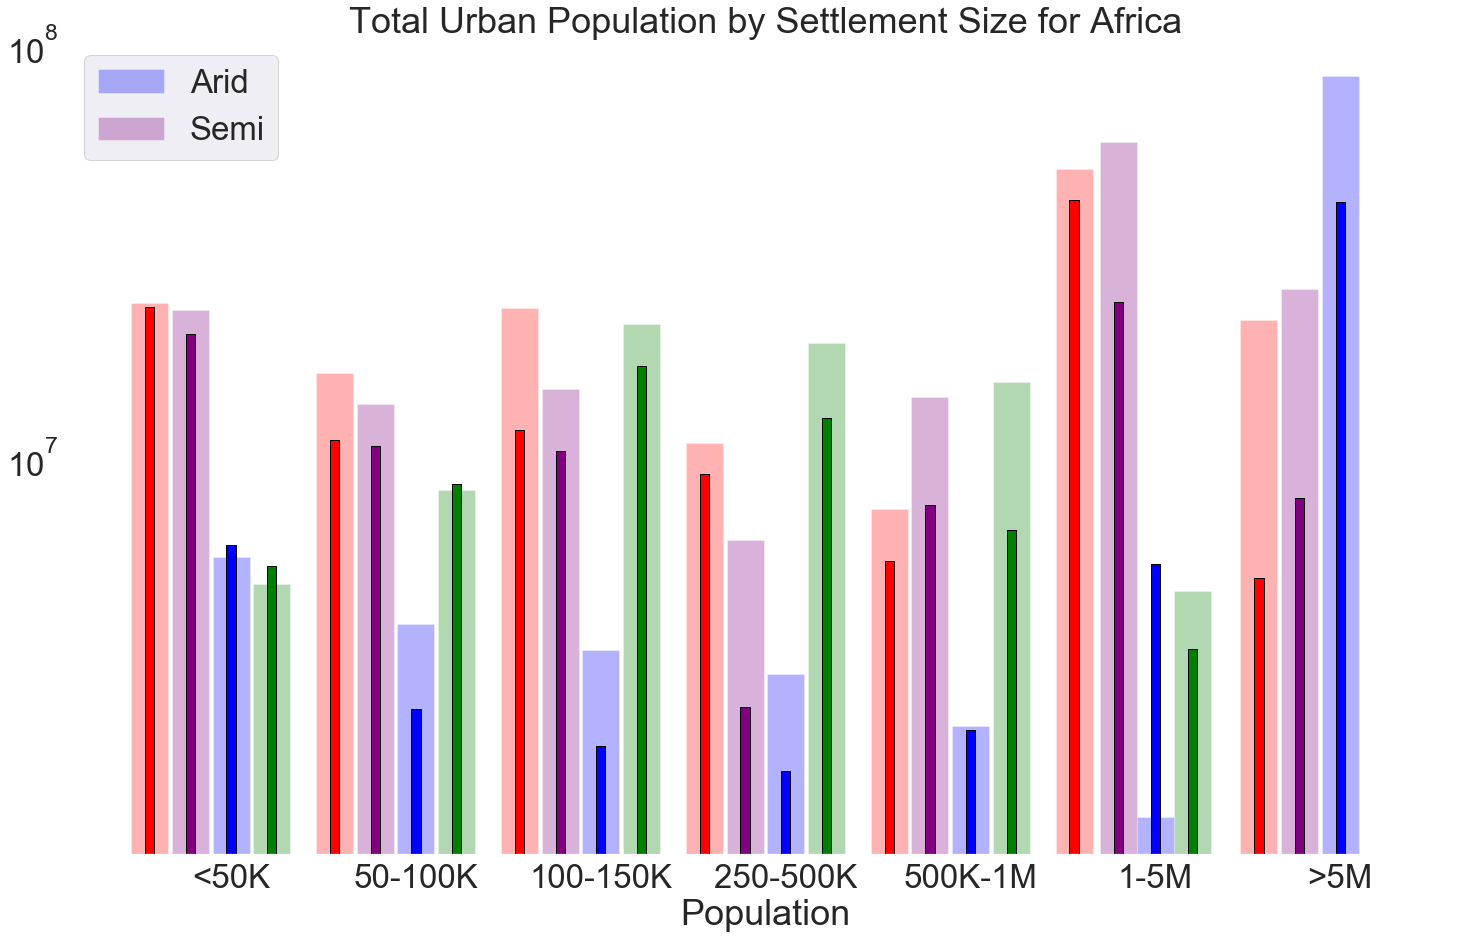

In [71]:
# make plot
sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
z = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
a = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2015
plt.bar(x, GHS2015_arid_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Blue')
plt.bar(y, GHS2015_semi_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Purple')
plt.bar(z, GHS2015_sub_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Red')
plt.bar(a, GHS2015_humid_bar.values(), width=0.2, align='center', alpha = 0.3, color = 'Green')

#2000
plt.bar(x, GHS2000_arid_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Blue', edgecolor = 'Black')
plt.bar(y, GHS2000_semi_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Purple', edgecolor = 'Black')
plt.bar(z, GHS2000_sub_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Red', edgecolor = 'Black')
plt.bar(a, GHS2000_humid_bar.values(), width=0.05, align='center', alpha = 1, color = 'Green', edgecolor = 'Black')

# bar_leg = ['WorldPop 2000 Arid', 'WorldPop 2000 Semi-arid', 'WorldPop 2000 Sub-humid', 'WorldPop 2000 Humid',
#           'WorldPop 2015 Arid', 'WorldPop 2015 Semi-arid', 'WorldPop 2015 Sub-humid', 'WorldPop 2015 Humid']

bar_leg = ['Arid', 'Semi']

plt.legend(bar_leg,loc=2)


plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
ax.set_facecolor('White')
# fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)



### Rain Zone Pct Change

In [74]:
arid_2000 = [GHS2000_arid_50k, GHS2000_arid_100k, GHS2000_arid_250k, GHS2000_arid_500k, GHS2000_arid_1m,
            GHS2000_arid_5m, GHS2000_arid_5mplus]

arid_2000_pct = np.round(arid_2000 / GHS2000.PopTot.sum() * 100, 1)

In [77]:
semi_2000 = [GHS2000_semi_50k, GHS2000_semi_100k, GHS2000_semi_250k, GHS2000_semi_500k, GHS2000_semi_1m,
            GHS2000_semi_5m, GHS2000_semi_5mplus]

semi_2000_pct = np.round(semi_2000 / GHS2000.PopTot.sum() * 100, 1)
semi_2000_pct 

array([6.3, 3.4, 3.3, 0.8, 2.4, 7.5, 2.5])

In [78]:
sub_2000 = [GHS2000_sub_50k, GHS2000_sub_100k, GHS2000_sub_250k, GHS2000_sub_500k, GHS2000_sub_1m,
            GHS2000_sub_5m, GHS2000_sub_5mplus]

sub_2000_pct = np.round(sub_2000 / GHS2000.PopTot.sum() * 100, 1)
sub_2000_pct 

array([ 7.3,  3.5,  3.7,  2.9,  1.8, 13.2,  1.6])

In [79]:
humid_2000 = [GHS2000_humid_50k, GHS2000_humid_100k, GHS2000_humid_250k, GHS2000_humid_500k, GHS2000_humid_1m,
            GHS2000_humid_5m, GHS2000_humid_5mplus]

humid_2000_pct = np.round(humid_2000 / GHS2000.PopTot.sum() * 100, 1)
humid_2000_pct 

array([1.7, 2.7, 5.2, 3.9, 2.1, 1.1, 0. ])

In [80]:
arid_2015 = [GHS2015_arid_50k, GHS2015_arid_100k, GHS2015_arid_250k, GHS2015_arid_500k, GHS2015_arid_1m,
            GHS2015_arid_5m, GHS2015_arid_5mplus]

arid_2015_pct = np.round(arid_2015 / GHS2015.PopTot.sum() * 100, 1)
arid_2015_pct 

array([ 1.2,  0.8,  0.7,  0.6,  0.4,  0.3, 16.9])

In [81]:
semi_2015 = [GHS2015_semi_50k, GHS2015_semi_100k, GHS2015_semi_250k, GHS2015_semi_500k, GHS2015_semi_1m,
            GHS2015_semi_5m, GHS2015_semi_5mplus]

semi_2015_pct = np.round(semi_2015 / GHS2015.PopTot.sum() * 100, 1)
semi_2015_pct 

array([ 4.6,  2.7,  2.9,  1.3,  2.8, 11.7,  5.1])

In [82]:
sub_2015 = [GHS2015_sub_50k, GHS2015_sub_100k, GHS2015_sub_250k, GHS2015_sub_500k, GHS2015_sub_1m,
            GHS2015_sub_5m, GHS2015_sub_5mplus]

sub_2015_pct = np.round(sub_2015 / GHS2015.PopTot.sum() * 100, 1)
sub_2015_pct 

array([ 4.8,  3.2,  4.6,  2.2,  1.5, 10. ,  4.3])

In [83]:
humid_2015 = [GHS2015_humid_50k, GHS2015_humid_100k, GHS2015_humid_250k, GHS2015_humid_500k, GHS2015_humid_1m,
            GHS2015_humid_5m, GHS2015_humid_5mplus]

humid_2015_pct = np.round(humid_2015 / GHS2015.PopTot.sum() * 100, 1)
humid_2015_pct 

array([1. , 1.7, 4.2, 3.8, 3.1, 1. , 0. ])

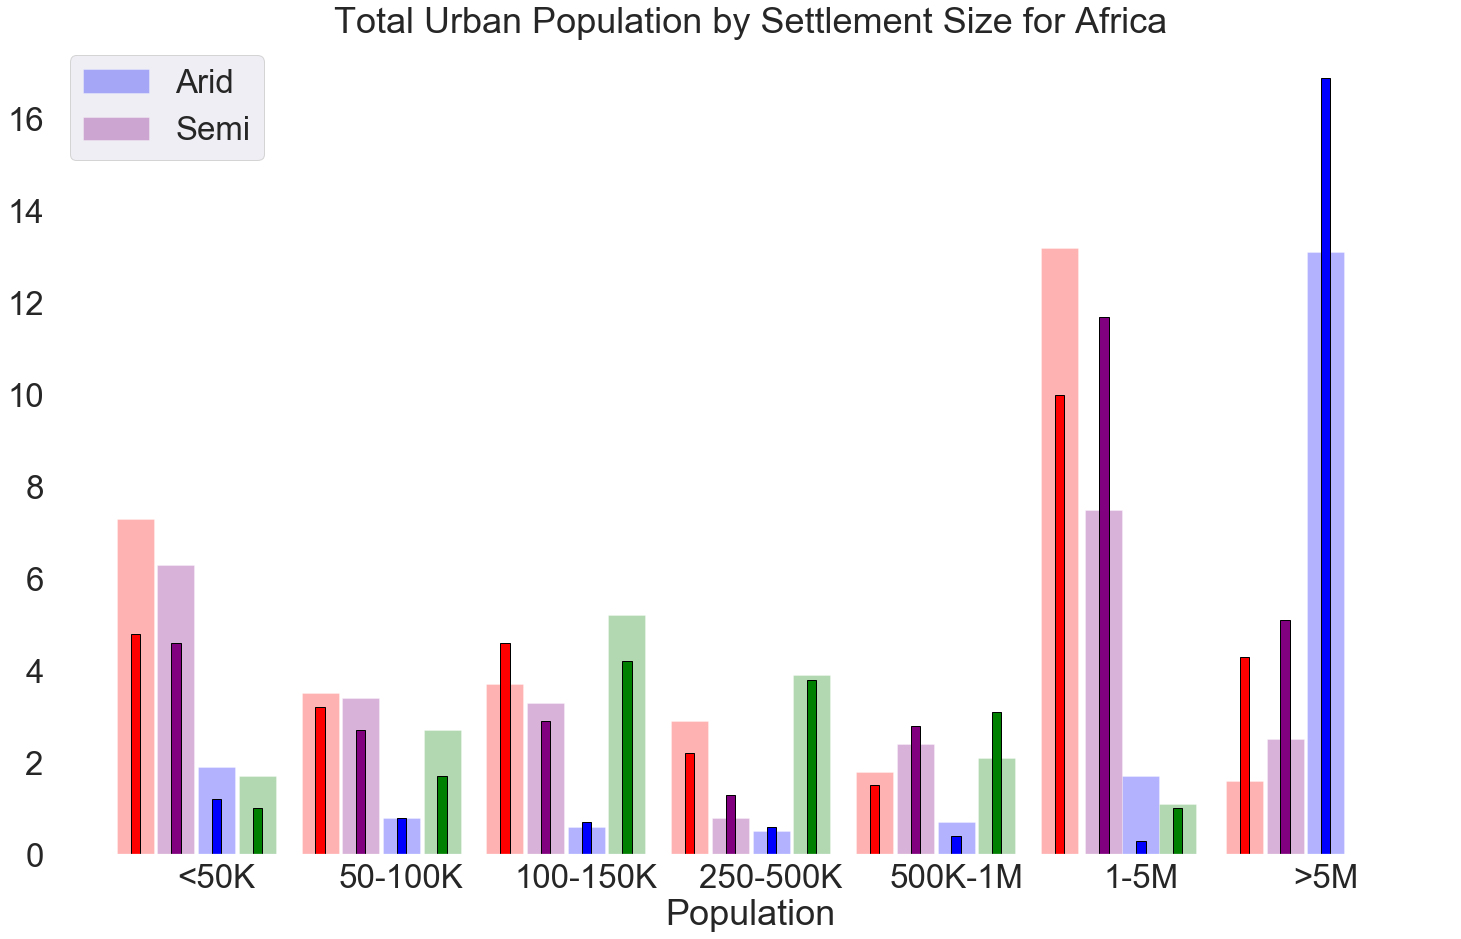

In [87]:
# Make some plots

# make plot
sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
z = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
a = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2000
plt.bar(x, arid_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Blue')
plt.bar(y, semi_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Purple')
plt.bar(z, sub_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Red')
plt.bar(a, humid_2000_pct, width=0.2, align='center', alpha = 0.3, color = 'Green')

#2000
plt.bar(x, arid_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Blue', edgecolor = 'Black')
plt.bar(y, semi_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Purple', edgecolor = 'Black')
plt.bar(z, sub_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Red', edgecolor = 'Black')
plt.bar(a, humid_2015_pct, width=0.05, align='center', alpha = 1, color = 'Green', edgecolor = 'Black')

# bar_leg = ['WorldPop 2000 Arid', 'WorldPop 2000 Semi-arid', 'WorldPop 2000 Sub-humid', 'WorldPop 2000 Humid',
#           'WorldPop 2015 Arid', 'WorldPop 2015 Semi-arid', 'WorldPop 2015 Sub-humid', 'WorldPop 2015 Humid']

bar_leg = ['Arid', 'Semi']

plt.legend(bar_leg,loc=2)


plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
#plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
ax.set_facecolor('White')
# fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)

### Pct Change by Rainfall Zone

In [116]:
# [a_i - b_i for a_i, b_i in zip(a, b)]

arid_delt = [(((a - b)/b)*100) for a, b in zip(arid_2015, arid_2000)]
semi_delt = [(((a - b)/b)*100) for a, b in zip(semi_2015, semi_2000)]
sub_delt = [(((a - b)/b)*100) for a, b in zip(sub_2015, sub_2000)]
humid_delt = [(((a - b)/b)*100) for a, b in zip(humid_2015[0:6], humid_2000[0:6])]


print(len(humid_delt))
humid_delt.append(0)
print(len(humid_delt))

6
7


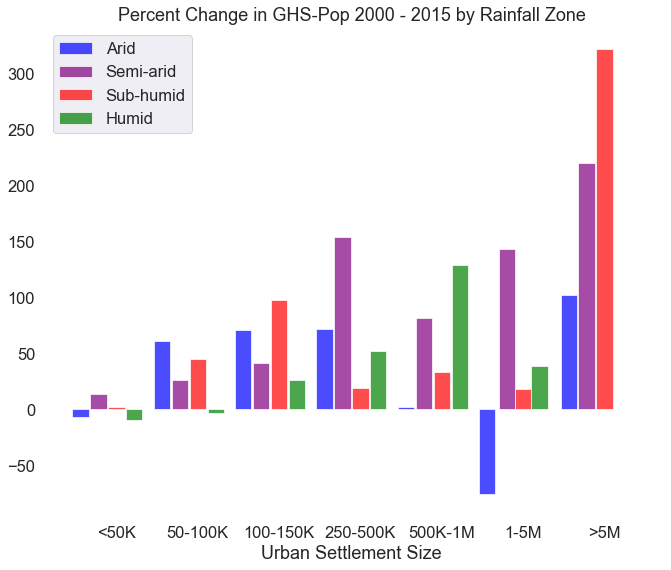

In [146]:
# Make some plots

# make plot
sns.set(font_scale=1.5)

a = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
b = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
c = [0,1,2,3,4,5,6]
d = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]


# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2000
plt.bar(a, arid_delt, width=0.2, align='center', alpha  = 0.7, color = 'Blue')
plt.bar(b, semi_delt, width=0.2, align='center', alpha  = 0.7, color = 'Purple')
plt.bar(c, sub_delt, width=0.2, align='center', alpha  = 0.7, color = 'Red')
plt.bar(d, humid_delt, width=0.2, align='center', alpha = 0.7, color = 'Green')

bar_leg = ['Arid', 'Semi-arid', 'Sub-humid', 'Humid']

plt.legend(bar_leg,loc=2)

plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 9)
#plt.gca().set_yscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('')
plt.title('Percent Change in GHS-Pop 2000 - 2015 by Rainfall Zone')
ax.set_facecolor('White')
fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_bar.png', dpi=700, transparent=False)



In [201]:
# Break up by Rain Zone 2000

GHS2000_rain = GHS2000[GHS2000['rain_zone'] != '0']
GHS2000_rain = GHS2000_rain[GHS2000_rain['rain_zone'] != 'NoClass']
GHS2000_rain =  GHS2000_rain[GHS2000_rain['rain_zone'] != 'NA']
GHS2000_rain['raincat'] = GHS2000_rain.rain_zone + ' 2000'

# Break up by Rain Zone 2015 & add unique col 
GHS2015_rain = GHS2015[GHS2015['rain_zone'] != '0']
GHS2015_rain = GHS2015_rain[GHS2015_rain['rain_zone'] != 'NoClass']
GHS2015_rain =  GHS2015_rain[GHS2015_rain['rain_zone'] != 'NA']
GHS2015_rain['raincat'] = GHS2015_rain.rain_zone + ' 2015'

# Join the two
datasets_rain = [GHS2000_rain, GHS2015_rain]
datasets_rain_concat = pd.concat(datasets_rain, ignore_index=True)


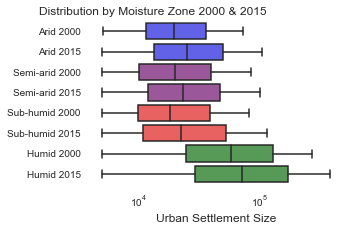

In [224]:
sns.set(font_scale=1)

plot_order = ['Arid 2000', 'Arid 2015', 'Semi-arid 2000', 'Semi-arid 2015',
              'Sub-humid 2000', 'Sub-humid 2015', 'Humid 2000', 'Humid 2015']

pal = ['Blue', 'Blue', 'Purple', 'Purple', 'Red', 'Red', 'Green', 'Green']

ax = sns.boxplot(x = 'PopTot', y = 'raincat', data = datasets_rain_concat, order = plot_order, palette = pal, 
                 sym = '')


# Add transparency to colors
for patch in ax.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .7))


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4.5, 3)
plt.gca().set_xscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Distribution by Moisture Zone 2000 & 2015', x = 0.25)
ax.set_facecolor('White')
fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_box.png', dpi=700, transparent=False,
           bbox_inches='tight')

In [233]:
round(datasets_rain_concat.groupby(['raincat']).PopTot.std())

raincat
Arid 2000         1684462.0
Arid 2015         4031795.0
Humid 2000         159929.0
Humid 2015         184550.0
Semi-arid 2000     317983.0
Semi-arid 2015     468956.0
Sub-humid 2000     291329.0
Sub-humid 2015     490580.0
Name: PopTot, dtype: float64

### Chunk by Dataset 

In [ ]:
# WP 2015 Chunks
WP2015_50k = WP2015.loc[(WP2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WP2015_50k)

WP2015_100k = WP2015.loc[(WP2015['PopTot'] > 5*10**4) & (WP2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(WP2015_100k)

WP2015_250k = WP2015.loc[(WP2015['PopTot'] > 10**5) & (WP2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WP2015_250k)

WP2015_500k = WP2015.loc[(WP2015['PopTot'] > 2.5*10**5) & (WP2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WP2015_500k)

WP2015_1m = WP2015.loc[(WP2015['PopTot'] > 5*10**5) & (WP2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(WP2015_1m)

WP2015_5m = WP2015.loc[(WP2015['PopTot'] > 10**6) & (WP2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WP2015_5m)

WP2015_5mplus = WP2015.loc[(WP2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WP2015_5mplus)

In [ ]:
# LS 2015 Chunks 

LS2015_50k = LS2015.loc[(LS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(LS2015_50k)

LS2015_100k = LS2015.loc[(LS2015['PopTot'] > 5*10**4) & (LS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(LS2015_100k)

LS2015_250k = LS2015.loc[(LS2015['PopTot'] > 10**5) & (LS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(LS2015_250k)

LS2015_500k = LS2015.loc[(LS2015['PopTot'] > 2.5*10**5) & (LS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(LS2015_500k)

LS2015_1m = LS2015.loc[(LS2015['PopTot'] > 5*10**5) & (LS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(LS2015_1m)

LS2015_5m = LS2015.loc[(LS2015['PopTot'] > 10**6) & (LS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(LS2015_5m)

LS2015_5mplus = LS2015.loc[(LS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(LS2015_5mplus)

In [ ]:
#GHS 2015 Chunks

GHS2015_50k = GHS2015.loc[(GHS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_50k)

GHS2015_100k = GHS2015.loc[(GHS2015['PopTot'] > 5*10**4) & (GHS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_100k)

GHS2015_250k = GHS2015.loc[(GHS2015['PopTot'] > 10**5) & (GHS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_250k)

GHS2015_500k = GHS2015.loc[(GHS2015['PopTot'] > 2.5*10**5) & (GHS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_500k)

GHS2015_1m = GHS2015.loc[(GHS2015['PopTot'] > 5*10**5) & (GHS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_1m)

GHS2015_5m = GHS2015.loc[(GHS2015['PopTot'] > 10**6) & (GHS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_5m)

GHS2015_5mplus = GHS2015.loc[(GHS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_5mplus)

In [ ]:
# WPE 2016 Chunks
WPE2016_50k = WPE2016.loc[(WPE2016['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WPE2016_50k)

WPE2016_100k = WPE2016.loc[(WPE2016['PopTot'] > 5*10**4) & (WPE2016['PopTot'] <= 10**5), 'PopTot'].sum()
print(WPE2016_100k)

WPE2016_250k = WPE2016.loc[(WPE2016['PopTot'] > 10**5) & (WPE2016['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WPE2016_250k)

WPE2016_500k = WPE2016.loc[(WPE2016['PopTot'] > 2.5*10**5) & (WPE2016['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WPE2016_500k)

WPE2016_1m = WPE2016.loc[(WPE2016['PopTot'] > 5*10**5) & (WPE2016['PopTot'] <= 10**6), 'PopTot'].sum()
print(WPE2016_1m)

WPE2016_5m = WPE2016.loc[(WPE2016['PopTot'] > 10**6) & (WPE2016['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WPE2016_5m)

WPE2016_5mplus = WPE2016.loc[(WPE2016['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WPE2016_5mplus)

In [ ]:
# WP 2000 Chunks
WP2000_50k = WP2000.loc[(WP2000['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WP2000_50k)

WP2000_100k = WP2000.loc[(WP2000['PopTot'] > 5*10**4) & (WP2000['PopTot'] <= 10**5), 'PopTot'].sum()
print(WP2000_100k)

WP2000_250k = WP2000.loc[(WP2000['PopTot'] > 10**5) & (WP2000['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WP2000_250k)

WP2000_500k = WP2000.loc[(WP2000['PopTot'] > 2.5*10**5) & (WP2000['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WP2000_500k)

WP2000_1m = WP2000.loc[(WP2000['PopTot'] > 5*10**5) & (WP2000['PopTot'] <= 10**6), 'PopTot'].sum()
print(WP2000_1m)

WP2000_5m = WP2000.loc[(WP2000['PopTot'] > 10**6) & (WP2000['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WP2000_5m)

WP2000_5mplus = WP2000.loc[(WP2000['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WP2000_5mplus)

In [ ]:
# GHS 2000 Chunks
GHS2000_50k = GHS2000.loc[(GHS2000['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_50k)

GHS2000_100k = GHS2000.loc[(GHS2000['PopTot'] > 5*10**4) & (GHS2000['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_100k)

GHS2000_250k = GHS2000.loc[(GHS2000['PopTot'] > 10**5) & (GHS2000['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_250k)

GHS2000_500k = GHS2000.loc[(GHS2000['PopTot'] > 2.5*10**5) & (GHS2000['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_500k)

GHS2000_1m = GHS2000.loc[(GHS2000['PopTot'] > 5*10**5) & (GHS2000['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_1m)

GHS2000_5m = GHS2000.loc[(GHS2000['PopTot'] > 10**6) & (GHS2000['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_5m)

GHS2000_5mplus = GHS2000.loc[(GHS2000['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_5mplus)

In [ ]:
# Chunks

WP2000_chunks = [WP2000_50k, WP2000_100k, WP2000_250k, WP2000_500k, WP2000_1m, WP2000_5m, WP2000_5mplus]
WP2015_chunks = [WP2015_50k, WP2015_100k, WP2015_250k, WP2015_500k, WP2015_1m, WP2015_5m, WP2015_5mplus]

GHS2000_chunks = [GHS2000_50k, GHS2000_100k, GHS2000_250k, GHS2000_500k, GHS2000_1m, GHS2000_5m, GHS2000_5mplus]
GHS2015_chunks = [GHS2015_50k, GHS2015_100k, GHS2015_250k, GHS2015_500k, GHS2015_1m, GHS2015_5m, GHS2015_5mplus]

LS2015_chunks = [LS2015_50k, LS2015_100k, LS2015_250k, LS2015_500k, LS2015_1m, LS2015_5m, LS2015_5mplus]

WPE2016_chunks = [WPE2016_50k, WPE2016_100k, WPE2016_250k, WPE2016_500k, WPE2016_1m, WPE2016_5m, WPE2016_5mplus]


In [ ]:
#datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

data_chunks = [GHS2000_chunks, GHS2015_chunks, WP2000_chunks, WP2015_chunks, LS2015_chunks, WPE2016_chunks] 

In [ ]:
# Percentages

GHS2000_chunks_pct = np.around(GHS2000_chunks / GHS2000.PopTot.sum() * 100, 1)
GHS2015_chunks_pct = np.around(GHS2015_chunks / GHS2015.PopTot.sum() * 100, 1)

WP2000_chunks_pct = np.around(WP2000_chunks / WP2000.PopTot.sum() * 100, 1)
WP2015_chunks_pct = np.around(WP2015_chunks / WP2015.PopTot.sum() * 100, 1)

LS2015_chunks_pct = np.around(LS2015_chunks / LS2015.PopTot.sum() * 100, 1)
WPE2016_chunks_pct = np.around(WPE2016_chunks / WPE2016.PopTot.sum() * 100, 1)

### Square Plot

http://gvallver.perso.univ-pau.fr/?p=700

In [ ]:
print(np.around(LS2015_chunks))
print(LS2015_chunks_pct)

In [ ]:
# Make Data 

data = np.around(WPE2016_chunks)
pct = WPE2016_chunks_pct
chunks = ['<50K:', '50-100K: ', '100-150K: ','250-500K: ', '500K-1M: ', '1-5M: ', '>5M: ']

labels = [chunks[0]+'\n'+str(pct[0])+'%',
         chunks[1]+'\n'+str(pct[1])+'%',
         chunks[2]+'\n'+str(pct[2])+'%',
         chunks[3]+'\n'+str(pct[3])+'%',
         chunks[4]+'\n'+str(pct[4])+'%',
         chunks[5]+'\n'+str(pct[5])+'%',
         chunks[6]+'\n'+str(pct[6])+'%'
         ]


In [ ]:
# set size
sns.set(font_scale=1.5)

# Set Colors
norm = matplotlib.colors.Normalize(vmin=min(data), vmax=max(data))
colors = [matplotlib.cm.Purples_r(norm(value)) for value in data]

# Create Plot
fig = plt.figure(figsize=(12, 10))
fig.suptitle("", fontsize=20)
ax = fig.add_subplot(111, aspect='equal')c
ax1 = squarify.plot(data, color = colors, label=labels, ax=ax, alpha = 0.7)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('World Population Estimate 2016 \n Urban Settlments Distribution')

# color bar
bar_number = data/(10**6)

# create dummy invisible image with a color map
img = plt.imshow([bar_number], cmap='Purples_r')
img.set_visible(False)
fig.colorbar(img, orientation="vertical", shrink=.96)
fig.text(.76, .9, "Population in Millions", fontsize=14)

fig.savefig('/Users/cascade/Desktop/'+'WPE2016_SquarePlot.png', dpi=700)


### Bar Charts

In [54]:
# import plotly.plotly as py
# import plotly.tools as tls

import matplotlib.pyplot as plt

dictionary = plt.figure()

WP2015_bar = {'<50K':WP2015_50k, '50-100K': WP2015_100k, '100-150K':WP2015_250k,
    '250-500K' : WP2015_500k, '500K-1M' : WP2015_1m, '1-5M' : WP2015_5m, '>5M' : WP2015_5mplus
             }

# WP2000_bar = {u'Label0':WP2000_50k, u'Label1': WP2000_100k, u'Label2':WP2000_250k,
#     u'Label3' : WP2000_500k, u'Label4' : WP2000_1m, u'Label5' : WP2000_5m, u'Label6' : WP2000_5mplus
#     }

LS2015_bar = {u'Label0':LS2015_50k, u'Label1': LS2015_100k, u'Label2':LS2015_250k,
    u'Label3' : LS2015_500k, u'Label4' : LS2015_1m, u'Label5' : LS2015_5m, u'Label6' : LS2015_5mplus
    }

GHS2015_bar = {u'Label0':GHS2015_50k, u'Label1': GHS2015_100k, u'Label2':GHS2015_250k,
    u'Label3' : GHS2015_500k, u'Label4' : GHS2015_1m, u'Label5' : GHS2015_5m, u'Label6' : GHS2015_5mplus
    }

WPE2016_bar = {u'Label0':WPE2016_50k, u'Label1': WPE2016_100k, u'Label2':WPE2016_250k,
    u'Label3' : WPE2016_500k, u'Label4' : WPE2016_1m, u'Label5' : WPE2016_5m, u'Label6' : WPE2016_5mplus
   }

# make plot
sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.2,1-.2,2-.2,3-.2,4-.2,5-.2,6-.2]
z = [0-.4,1-.4,2-.4,3-.4,4-.4,5-.4,6-.4]
a = [0+.2,1+.2,2+.2,3+.2,4+.2,5+.2,6+.2]



plt.bar(x, WP2015_bar.values(), width=0.2, align='center', alpha  = 0.7, color = 'Blue')

plt.bar(y, LS2015_bar.values(), width=0.2, align='center', alpha  = 0.7, color = 'Green')
plt.bar(z, GHS2015_bar.values(), width=0.2, align='center', alpha  = 0.7, color = 'Orange')
plt.bar(a, WPE2016_bar.values(), width=0.2, align='center', alpha = 0.7, color = 'Purple')

bar_leg = ['WorldPop 2015', 'LandScan 2015', 'GHS-Pop 2015', 'ESRI-WPE 2016']
plt.legend(bar_leg,loc=2)



#plt.bar(range(len(D)), D.values(), align='center')

plt.xticks(range(len(WP2015_bar)), WP2015_bar.keys())

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
#fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)


# ax.bar(x-0.2, y,width=0.2,color='b',align='center')
# ax.bar(x, z,width=0.2,color='g',align='center')
# ax.bar(x+0.2, k,width=0.2,color='r',align='center')

NameError: name 'WP2015_50k' is not defined

<Figure size 432x288 with 0 Axes>

### Chunk by Country

In [ ]:
# Chunk by country 

WP2015_Nigeria = WP2015[WP2015['country']=='Ghana']
cLS2015_Nigeria = LS2015[LS2015['country']=='Ghana']
GHS2015_Nigeria = GHS2015[GHS2015['country']=='Ghana']
WPE2016_Nigeria = WPE2016[WPE2016['country']=='Ghana']

print(len(WP2015_Nigeria))
print(len((LS2015_Nigeria)))
print(len((GHS2015_Nigeria)))
print(len((WPE2016_Nigeria)))

In [ ]:
# import plotly.plotly as py
# import plotly.tools as tls

import matplotlib.pyplot as plt

dictionary = plt.figure()

bar_leg = ['WorldPop 2015', 'WorldPop 2000']


WP2015_Nigeria_bar = {'<50K':WP2015_Nigeria_50k, '50-100K': WP2015_Nigeria_100k, '100-150K':WP2015_Nigeria_250k,
    '250-500K' : WP2015_Nigeria_500k, '500K-1m' : WP2015_Nigeria_1m, '1-5M' : WP2015_Nigeria_5m, '>5M' : WP2015_Nigeria_5mplus
             }

WP2000_Nigeria_bar = {u'Label0':WP2000_Nigeria_50k, u'Label1': WP2000_Nigeria_100k, u'Label2':WP2000_Nigeria_250k,
    u'Label3' : WP2000_Nigeria_500k, u'Label4' : WP2000_Nigeria_1m, u'Label5' : WP2000_Nigeria_5m, u'Label6' : WP2000_Nigeria_5mplus
    }

# make plot
sns.set(font_scale=2.2)

plt.bar(range(len(WP2000_Nigeria_bar)), WP2000_Nigeria_bar.values(), align='center', alpha  = 0.5, color = 'Purple')
plt.bar(range(len(WP2015_Nigeria_bar)), WP2015_Nigeria_bar.values(), align='center', alpha = 0.5, color = 'Orange')
plt.legend(bar_leg,loc=2)


#plt.bar(range(len(D)), D.values(), align='center')

plt.xticks(range(len(WP2015_Nigeria_bar)), WP2015_Nigeria_bar.keys())

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().set_yscale('log')
#fig.savefig('/Users/cascade/Desktop/'+'WP152000_Nigeria_bar.png', dpi=700)

In [ ]:
# WP 2000 & 2000 Bar Plots Chunk by City Size

# drop FID
print(len(WP2015))
WP2015 = WP2015.drop_duplicates('FID', keep = 'first')
print(len(WP2015))

# drop <5000
WP2015 = WP2015[WP2015['PopTot'] > 5000]
print(len(WP2015))

In [ ]:
WP2015_aez = WP2015[WP2015['aez_class'] != '0']
WP2015_aez = WP2015_aez[WP2015_aez['aez_class'] != 'NoClass']

# ax = sns.boxplot(x = 'PopTot', y = 'aez_class', data = WP2000_aez)
# ax.set(xscale="log")

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.55)
# plt.xlabel('Population')
# plt.ylabel('')
# plt.title('WP2000 Distribution by AEZ')

# # fig.savefig('test2png.png', dpi=100)

In [ ]:
WP_med2015 = round(WP2015_aez.groupby('aez_class')['PopTot'].median())

In [ ]:
#  66313.0 - 2000
WP_med2015

In [ ]:
WP_med2000

In [ ]:
WP2000_aez = WP2000[WP2000['aez_class'] != '0']
WP2000_aez = WP2000_aez[WP2000_aez['aez_class'] != 'NoClass']
WP2015_aez = WP2015[WP2015['aez_class'] != '0']
WP2015_aez = WP2015_aez[WP2015_aez['aez_class'] != 'NoClass']

# ax = sns.boxplot(x = 'PopTot', y = 'aez_class', data = WP2000_aez)
# ax.set(xscale="log")

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.55)
# plt.xlabel('Population')
# plt.ylabel('')
# plt.title('WP2000 Distribution by AEZ')

#fig.savefig('/Users/cascade/Desktop/'+'WP2000_aez.png', dpi=700)


In [ ]:
round(WP2000_aez.groupby('aez_class')['PopTot'].median())

In [ ]:
round(WP2015_aez.groupby('aez_class')['PopTot'].median())

In [ ]:
100*((496037 - 361052)/361052)

In [ ]:
# add col for concat, drop FID duplicates

datasets_string = ['GHS2000', 'GHS2015', 'WP2000', 'WP2015', 'LS2015', 'WPE2016']

# for i, dataset in enumerate(datasets_in):
    
#     dataset['dataset'] = datasets_string[i]
#     dataset = dup_drop(dataset, 'FID', 'first')

WPE2016['dataset'] = 'WPE2016'
WPE2016 = dup_drop(WPE2016, 'FID', 'first')

In [ ]:
# drop cities with less than 5000 
GHS2015 = GHS2015[GHS2015['PopTot']>=5000] 
WP2015 = WP2015[WP2015['PopTot']>=5000] 
LS2015 = LS2015[LS2015['PopTot']>=5000] 
WPE2016 = WPE2016[WPE2016['PopTot']>=5000] 


datasets2015 = [GHS2015, WP2015, LS2015, WPE2016]


datasets15_concat = pd.concat(datasets2015, ignore_index=True)

# datasets_concat = pd.concat(datasets_in, ignore_index=True)

In [ ]:
datasets15_concat.shape

In [ ]:
min(WPE2016['PopTot'])

In [ ]:
sns.set(font_scale=3)
ax = sns.boxplot(x = 'PopTot', y = 'dataset', data = datasets15_concat)
ax.set(xscale="log") 
plt.xlabel('Population')
plt.ylabel('')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

#fig.savefig('/Users/cascade/Desktop/'+'data15-hist.png', dpi=700)

In [ ]:
datasets2015 = [GHS2015, WP2015, LS2015, WPE2016]


GHS2015_sort = GHS2015['PopTot'].sort_values()
X0, y0 = p_X_gt_x(GHS2015_sort)

WP2015_sort = WP2015['PopTot'].sort_values()
X1, y1 = p_X_gt_x(WP2015_sort)

LS2015_sort = LS2015['PopTot'].sort_values()
X2, y2 = p_X_gt_x(LS2015_sort )

WPE2016_sort = WPE2016['PopTot'].sort_values()
X3, y3 = p_X_gt_x(WPE2016_sort)


In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(X0, y0, label ='GHS2015')
ax.plot(X1, y1, label ='WP2015')
ax.plot(X2, y2, label ='LS2015')
ax.plot(X3, y3, label ='WPE2016')
plt.xscale('log')
plt.title('Inverse cumulative distribution of city sizes by dataset')
plt.xlabel('x(Population)')
plt.ylabel('P[X>=x]')
ax.legend()
fig.set_size_inches(18.5, 10.5)


In [ ]:
#GHS2000.loc[(GHS2000['PopTot'] > 5000) & (GHS2000['PopTot'] < 10000), 'PopTot'].sum()
test = GHS2015[GHS2015['PopTot'] <5000000]

a =test.loc[(test['PopTot'] > 1000000), 'PopTot'].sum()
                                         
                                          
#GHS2000.loc[GHS2000['PopTot'] <50000 & GHS2000['PopTot'] >5000, 'PopTot'].sum()

In [ ]:
import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
 # just as an example array
pp.plot(a, 'x')
pp.show()

In [ ]:
WPE2016.head()

a = GHS2015[GHS2015['PopTot']>0]
a = GHS2015[GHS2015['PopTot']<1000000]
b = GHS2000[GHS2000['PopTot']>0]
b = GHS2000[GHS2000['PopTot']<1000000]


plt.hist(np.log10(b['PopTot']), alpha=0.5, label='WP2000')
plt.hist(np.log10(a['PopTot']), alpha=0.5, label='WP2015')
#plt.hist(np.log10(LS2015['PopTot']), alpha=0.5, label='x')
#plt.hist(np.log10(a['PopTot']), alpha=0.5, label='x')



plt.legend(loc='upper right')
# plt.show()


## Pairwise Grouping

In [ ]:
Drop Doubles based on OSM Lat/Lon

GHS2000_drop = dup_drop(GHS2000, 'osm_id', 'first')
WP2000_drop = dup_drop(WP2000, 'osm_id', 'first')

GHS2015_drop = dup_drop(GHS2015, 'osm_id', 'first')
WP2015_drop = dup_drop(WP2015 , 'osm_id', 'first')
LS2015_drop = dup_drop(LS2015 , 'osm_id', 'first')
WPE2016_drop = dup_drop(WPE2016 , 'osm_id', 'first')

In [ ]:
GHS2015_pop = GHS2015_drop[['str_id','PopTot']]
WP2015_pop = WP2015_drop[['str_id','PopTot']]
LS2015_pop = LS2015_drop[['str_id','PopTot']]
WPE2016_pop = WPE2016_drop[['str_id','PopTot']]

data_frames = [GHS2015_pop, WP2015_pop, LS2015_pop, WPE2016_pop]

df2015_merged = reduce(lambda  left,right: pd.merge(left,right,on=['str_id'], how='inner'), data_frames)

print(len(df2015_merged))
df2015_merged.head(4)


In [ ]:
df2015_merged.columns = ['str_id', 'GHS15_Pop', 'WP15_Pop', 'LS15_Pop', 'WPE2016_pop' ]
df2015_merged.head()

In [ ]:
df_2015_GHS_WP = df2015_merged[['WPE2016_pop','LS15_Pop']]
print(df_2015_GHS_WP.shape)


df_2015_GHS_WP = df_2015_GHS_WP.drop_duplicates(keep='first')
print(df_2015_GHS_WP.shape)


In [ ]:
stats.pearsonr(df_2015_GHS_WP['WPE2016_pop'], df_2015_GHS_WP['LS15_Pop'])

In [ ]:
df_2015_GHS_WP.dtypes

In [ ]:
# Pairwise scatter plots

fig = plt.figure()
ax = plt.gca()
ax.scatter(df_2015_GHS_WP['WPE2016_pop'], df_2015_GHS_WP['LS15_Pop'] , c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('ESRI - WPE 2016')
plt.ylabel('LandScan 2015')

#fig.savefig('/Users/cascade/Desktop/'+'WPE16-LS15.png', dpi=700)

In [ ]:
#axl = pd.scatter_matrix(df2015_merged, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

import seaborn as sns
corr = df2015_merged.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
import matplotlib.pyplot as plt

#matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_drop['PopTot_x'], test_df_drop['PopTot_y'] , c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_drop['x'], test_df_drop['y'], c='blue', alpha=0.1, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

In [ ]:
from scipy import stats
xA = df_merge['PopTot_x']
yA = df_merge['PopTot_y']

result = stats.pearsonr(xA, yA) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
from scipy import stats
xR = test_df_drop['x']
yR = test_df_drop['y']

result = stats.pearsonr(xR, yR) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
test_df_min = test_df_drop[test_df_drop['x']<=1000000]
print(len(test_df_min))
test_df_min = test_df_drop[test_df_drop['y']<=1000000]
print(len(test_df_min))

In [ ]:
test_df_min[test_df_min['y']>=1000000]

In [ ]:
xW = test_df_min['x']
yW = test_df_min['y']

result = stats.pearsonr(xW, yW) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_min['x'], test_df_min['y'], c='blue', alpha=0.1, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

# Old Code

In [ ]:
# df_test_a = WP2015[['osm_id', 'PopTot']]


# df_test_b = GHS2015[['osm_id', 'PopTot']]
# print(df_test_b.shape)
# print(df_test_a.shape)

# df_test_a_drop = df_test_a.drop_duplicates('osm_id', keep=False)
# df_test_b_drop = df_test_b.drop_duplicates('osm_id', keep=False)
# print(df_test_b_drop.shape)
# print(df_test_a_drop.shape)

In [ ]:
# find duplicates

# dupsA = pd.concat(g for _, g in test_df.groupby("str_id") if len(g) > 1)
# dupsA

In [ ]:
# x = df_merge['PopTot_x']
# y = df_merge['PopTot_y']
# str_id_merge = df_merge['str_id']
# test_df = pd.DataFrame()
# test_df['x'] = x
# test_df['y'] = y
# test_df['str_id_merge'] = str_id_merge



# test_df['x_string'] = test_df.x.astype(str)
# test_df['y_string'] = test_df.y.astype(str)
# test_df['str_id'] = test_df.x_string.astype(str)+test_df.y_string.astype(str)

In [ ]:
#axl = pd.scatter_matrix(df2015_merged, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

# import seaborn as sns
# corr = df2015_merged.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

In [ ]:
# import matplotlib.pyplot as plt

# #matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_drop['PopTot_x'], test_df_drop['PopTot_y'] , c='blue', alpha=0.05, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_drop['x'], test_df_drop['y'], c='blue', alpha=0.1, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# from scipy import stats
# xA = df_merge['PopTot_x']
# yA = df_merge['PopTot_y']

# result = stats.pearsonr(xA, yA) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# from scipy import stats
# xR = test_df_drop['x']
# yR = test_df_drop['y']

# result = stats.pearsonr(xR, yR) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# test_df_min = test_df_drop[test_df_drop['x']<=1000000]
# print(len(test_df_min))
# test_df_min = test_df_drop[test_df_drop['y']<=1000000]
# print(len(test_df_min))

In [ ]:
# test_df_min[test_df_min['y']>=1000000]

In [ ]:
# xW = test_df_min['x']
# yW = test_df_min['y']

# result = stats.pearsonr(xW, yW) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_min['x'], test_df_min['y'], c='blue', alpha=0.1, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# # WP 2000 & 2015 Bar Plots Chunk by City Size

# # drop FID
# print(len(WP2015))
# WP2015 = WP2015.drop_duplicates('FID', keep = 'first')
# print(len(WP2015))

# # drop <5000
# WP2015 = WP2015[WP2015['PopTot'] > 5000]
# print(len(WP2015))

# # WP 2000 & 2015 Bar Plots Chunk by City Size

# # drop FID
# print(len(WP2015))
# LS2015 = LS2015.drop_duplicates('FID', keep = 'first')
# print(len(LS2015))

# # drop <5000
# GHS2015 = GHS2015[GHS2015['PopTot'] > 5000]
# print(len(GHS2015))

# # WP 2000 & 2015 Bar Plots Chunk by City Size

# # drop FID
# print(len(WPE2016))
# WPE2016 = WPE2016.drop_duplicates('FID', keep = 'first')
# print(len(WPE2016))

# # drop <5000
# WPE2016 = WPE2016[WPE2016['PopTot'] > 5000]
# print(len(WPE2016))


In [ ]:
# # Loop through datasets to drop FID duplicates and remove cities with population less than 5000

# for dataset in datasets_in:
    
#     # drop FID
#     print(len(dataset))
#     dataset = dataset.drop_duplicates('FID', keep = 'first')
#     print(len(dataset))
    
#     # drop <5000
#     dataset = dataset[dataset['PopTot'] > 5000]

#     print(len(dataset))

In [ ]:
# # set size
# sns.set(font_scale=1.5)

# # Set Colors
# norm = matplotlib.colors.Normalize(vmin=min(data), vmax=max(data))
# colors = [matplotlib.cm.Purples_r(norm(value)) for value in data]

# # Create Plot
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle("", fontsize=20)
# ax = fig.add_subplot(111, aspect='equal')c
# ax1 = squarify.plot(data, color = colors, label=labels, ax=ax, alpha = 0.7)

# # Remove ticks
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_title('World Population Estimate 2016 \n Urban Settlments Distribution')

# # color bar
# bar_number = data/(10**6)

# # create dummy invisible image with a color map
# img = plt.imshow([bar_number], cmap='Purples_r')
# img.set_visible(False)
# fig.colorbar(img, orientation="vertical", shrink=.96)
# fig.text(.76, .9, "Population in Millions", fontsize=14)

# #fig.savefig('/Users/cascade/Desktop/'+'WPE2016_SquarePlot.png', dpi=700)


In [ ]:
# # Make Data 

# data = np.around(WPE2016_chunks)
# pct = WPE2016_chunks_pct
# chunks = ['<50K:', '50-100K: ', '100-150K: ','250-500K: ', '500K-1M: ', '1-5M: ', '>5M: ']

# labels = [chunks[0]+'\n'+str(pct[0])+'%',
#          chunks[1]+'\n'+str(pct[1])+'%',
#          chunks[2]+'\n'+str(pct[2])+'%',
#          chunks[3]+'\n'+str(pct[3])+'%',
#          chunks[4]+'\n'+str(pct[4])+'%',
#          chunks[5]+'\n'+str(pct[5])+'%',
#          chunks[6]+'\n'+str(pct[6])+'%'
#          ]


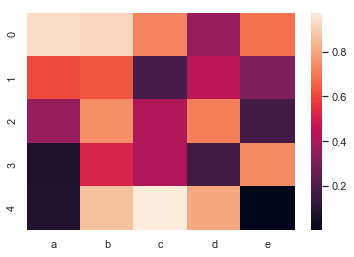

In [234]:
# x = list(range(0, len(GHS2000.PopTot)))
# y = GHS2000.PopTot.sort_values(ascending=True)

# plt.gca().set_yscale('log')
# plt.plot(x,y)

# print(len(x))
# print(len(y))

# library
import seaborn as sns
import pandas as pd
import numpy as np
 
# Create a dataset (fake)
df = pd.DataFrame(np.random.random((5,5)), columns=["a","b","c","d","e"])
 
# Default heatmap: just a visualization of this square matrix
p1 = sns.heatmap(df)

In [242]:
# create dataset
x = list(range(0, len(GHS2000.PopTot)))
y = list(range(0, len(GHS2000.PopTot)))

In [245]:
len(y)

3858

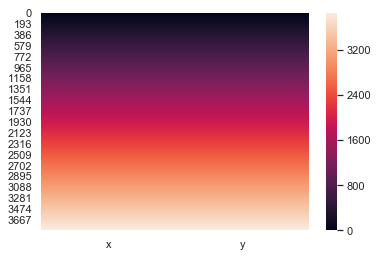

In [253]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y

df.shape

#pop = GHS2000.PopTot.sort_values(ascending=True)
 
# create heatmap
sns.heatmap(df)

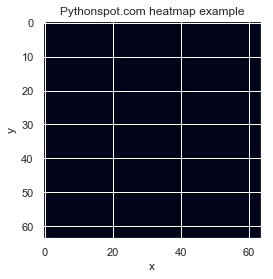

In [257]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
# Create data
x = GHS2000.PopTot.sort_values(ascending=True)
y = GHS2000.PopTot.sort_values(ascending=True)

#y = np.random.randn(4096)
 
# Create heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.title('Pythonspot.com heatmap example')
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap)
plt.show()